In [1]:
import sys
sys.path.append('../../image_processing/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
    
# plt.style.use("seaborn")
# sns.set(font_scale=1)

from pathlib import Path
import os
import gc
import functools 
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from apex import amp
import dill

import os, glob
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchsummary import summary
# from torch.utils.tensorboard import SummaryWriter

from resize import *
# from unet3d.model import ResidualUNet3D
# from unet3d.losses import *
# from unet3d.utils import create_feature_maps
# from unet3d.buildingblocks import Encoder, Decoder, FinalConv, ExtResNetBlock, SingleConv

# from fastai.vision import *


In [2]:
data_path = Path('/data/public/MIM_BMETS_V6')
train_img_path = data_path/'3_final_datasets/manuscript_1_datasets/first_tx_1met/training/skull_stripped_1x1x3'
train_mask_path = data_path/'3_final_datasets/manuscript_1_datasets/first_tx_1met/training/mets_masks_1x1x3'
valid_img_path = data_path/'3_final_datasets/manuscript_1_datasets/first_tx_1met/validation/skull_stripped_1x1x3'
valid_mask_path = data_path/'3_final_datasets/manuscript_1_datasets/first_tx_1met/validation/mets_masks_1x1x3'
test_img_path = data_path/'3_final_datasets/manuscript_1_datasets/first_tx_1met/testing/skull_stripped_1x1x3'
test_mask_path = data_path/'3_final_datasets/manuscript_1_datasets/first_tx_1met/testing/mets_masks_1x1x3'

In [3]:
train_img_files = sorted([str(train_img_path/file) for file in os.listdir(train_img_path)])
train_mask_files = sorted([str(train_mask_path/mask) for mask in os.listdir(train_mask_path)])
valid_img_files = sorted([str(valid_img_path/file) for file in os.listdir(valid_img_path)])
valid_mask_files = sorted([str(valid_mask_path/mask) for mask in os.listdir(valid_mask_path)])
test_img_files = sorted([str(test_img_path/file) for file in os.listdir(test_img_path)])
test_mask_files = sorted([str(test_mask_path/mask) for mask in os.listdir(test_mask_path)])
img_files = sorted(train_img_files+valid_img_files+test_img_files)
mask_files = sorted(train_mask_files+valid_mask_files+test_mask_files)
img_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in img_files]
mask_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in mask_files]
train_img_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in train_img_files]
train_mask_names = ['_'.join(file.split('/')[-1].split('_')[0:2]) for file in train_mask_files]
assert img_names==mask_names

In [4]:
def read_and_crop_to_tensor(file,target_d=None,target_h=None,target_w=None):
    img = np.load(file)
    d, h, w = img.shape
    if (target_d == None):
        target_d = d
    if (target_h == None):
        target_h = h
    if (target_w == None):
        target_w = w
    img = xyz_pad(np.load(file),target_d,target_h,target_w)
    return img

In [5]:
def show_single_pair(img,mask,index):
    figs,axes = plt.subplots(1,2)
    axes[0].imshow(img[index])
    axes[1].imshow(mask[index])

In [6]:
img = read_and_crop_to_tensor(train_img_files[0])
mask = read_and_crop_to_tensor(train_mask_files[0])

In [7]:
# show_single_pair(img,mask,39)

## Flip

In [8]:
def flip(img, mask, axis):
    """flips each slice  along horizontal axis"""
    if axis=='d':
        return np.flip(img, axis=0), np.flip(mask, axis=0)
    if axis=='h':
        return np.flip(img, axis=1), np.flip(mask, axis=1)
    if axis=='w':
        return np.flip(img, axis=2), np.flip(mask, axis=2)

#### depth

In [9]:
# flipped_img, flipped_mask = flip(mask, mask, 'd')

In [10]:
# show_single_pair(img,mask,39)

In [11]:
# show_single_pair(np.flip(img, axis=0),np.flip(mask, axis=0),64-39-1)

In [12]:
# np.all(np.flip(img, axis=0)[64-39-1] == img[39])

#### height

In [13]:
# flipped_img = flip(img,'h')
# flipped_mask = flip(mask,'h')

In [14]:
# show_single_pair(img,mask,39)

In [15]:
# show_single_pair(flipped_img,flipped_mask,39)

#### width

In [16]:
# flipped_img = flip(img,'w')
# flipped_mask = flip(mask,'w')

In [17]:
# show_single_pair(img,mask,39)

In [18]:
# show_single_pair(flipped_img,flipped_mask,39)

## Zoom and Crop

In [19]:
from scipy import ndimage

In [102]:
def crop_zoom(image, mask, max_h_zoom=1.2, max_w_zoom=1.2):
    h_zoom = np.random.randint(10,max_h_zoom*10)/10.
    w_zoom = np.random.randint(10,max_w_zoom*10)/10.
    zoom = (1, h_zoom, w_zoom)
    image = ndimage.zoom(image, zoom)
    mask = ndimage.zoom(mask, zoom)
    _, x, y = image.shape
    cropx, cropy = (x-256)//2, (y-256)//2
    image = image[:,cropx+1:x-cropx, cropy+1:y-cropy].copy()
    mask = (mask[:,cropx+1:x-cropx, cropy+1:y-cropy].copy() > 0.5).astype(float)
    return image, mask

In [21]:
# zoomed_img,zoomed_mask = crop_zoom(img,mask)

In [22]:
# show_single_pair(img,mask,39)

In [23]:
# show_single_pair(zoomed_img,zoomed_mask,39)

## Rotate

In [24]:
import cv2
def rotate(image_voxel, mask_voxel, angle=15):
    """rotate by +-angle"""
    H, W = mask_voxel.shape[1], mask_voxel.shape[2]
    angle = np.random.randint(-angle, angle, size=1)
    M = cv2.getRotationMatrix2D((H / 2, W / 2), angle, 1)
    image_voxel = np.array([cv2.warpAffine(slice_, M, (H, W)) for slice_ in image_voxel])
    mask_voxel = np.array([cv2.warpAffine(slice_, M, (H, W)) for slice_ in mask_voxel])
    return image_voxel, mask_voxel

In [25]:
# rotated_img,rotated_mask = random_rotate_3D_transform2(img,mask)

In [26]:
# show_single_pair(img,mask,39)

In [27]:
# show_single_pair(rotated_img,rotated_mask,39)

## Transformer

In [28]:
from scipy import ndimage
import cv2

In [103]:
class Transformer():
    
    def __init__(self,axes, max_zoom_rate, angle):
        self.max_zoom_rate = max_zoom_rate
        self.angle = angle
        self.axes = axes
        
#     def transform(self,img,mask):
#         pipeline = [self.flip,self.random_rotate_3D_transform2,self.crop_zoom]
#         for func in pipeline:
#             img,mask = func(img,mask)
#         return img,mask
    def transform(self, img, mask):
        trans = np.random.choice([flip, crop_zoom, rotate], 1)
        print(trans)
        if trans == flip:
            axis = np.random.choice(self.axes)
            return flip(img, mask, axis)
        if trans == crop_zoom:
            return crop_zoom(img, mask, max_h_zoom=self.max_zoom_rate, max_w_zoom=self.max_zoom_rate)
        if trans ==rotate:
            return rotate(img, mask, angle=self.angle)

In [104]:
transformer = Transformer(['d', 'h', 'w'], 1.5, 15)

In [110]:
tran_img, tran_mask = transformer.transform(img,mask)

[<function crop_zoom at 0x7fb83b594c80>]


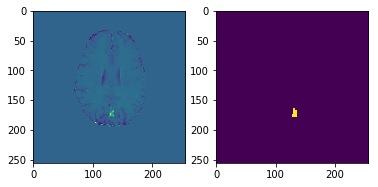

In [86]:
show_single_pair(img,mask,39)

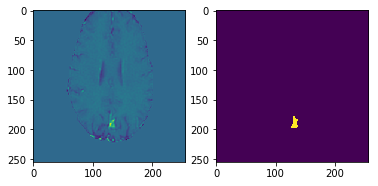

In [111]:
show_single_pair(tran_img, tran_mask,39)

In [77]:
transformer = Transformer('h',1,5)
for i in tqdm(range(500-len(train_img_files))):
    index = np.random.choice(range(len(train_img_files)))
    img = read_and_crop_to_tensor(train_img_files[index])
    mask = read_and_crop_to_tensor(train_mask_files[index])
    probability = np.random.uniform(0,1,3)
    if probability[0]>0.5:
        transformer.axis = np.random.choice(['h','w'])
        img, mask = transformer.flip(img, mask)
    if probability[1]>0.5:
        transformer.angle = np.random.uniform(-30,30,1)[0]
#         print(transformer.angle)
        img, mask = transformer.rotate(img, mask)
    if probability[2]>0.5:
        transformer.zoom_rate = np.random.uniform(0.5,1.5,1)[0]
        img, mask = transformer.crop_zoom(img, mask)
    img = xy_pad(img,256, 256)
    mask = xy_pad(mask,256, 256)
    assert 'aug_'+str(i)+'_'+train_img_names[index] == 'aug_'+str(i)+'_'+train_mask_names[index]
#     show_single_pair(img,mask,mask.argmax()//(256*256)+2)
#     plt.show()
    assert img.shape == mask.shape
#     print(img.shape)
    assert img.shape == (64,256,256)
    np.save('./aug_data/1met-500/training/skull_stripped/'+'aug_'+str(i)+'_'+train_img_names[index],img)
    np.save('./aug_data/1met-500/training/mets_masks/'+'aug_'+str(i)+'_'+train_mask_names[index],mask)

  1%|          | 2/376 [00:01<06:44,  1.08s/it]/home/chens/anaconda3/envs/schen/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|██████████| 376/376 [12:04<00:00,  1.93s/it]


In [ ]:
show_single_pair(img,mask,32)

In [ ]:
len(os.listdir('./aug_data/training/skull_stripped'))

In [ ]:
# def transform(img,mask):
#     pipeline = [flip,random_rotate_3D_transform2,crop_zoom]
#     for func in pipeline:
#         img,mask = func(img,mask)
#     return img,mask

# def flip(self, img, mask):
#     axis = self.axis
#     """flips each slice  along horizontal axis"""
#     if axis=='d':
#         return np.flip(img, axis=0),np.flip(mask, axis=0)
#     if axis=='h':
#         return np.flip(img, axis=1),np.flip(mask, axis=1)
#     if axis=='w':
#         return np.flip(img, axis=2),np.flip(mask, axis=2)

# def random_rotate_3D_transform2(self,image_voxel, mask_voxel):
#     """rotate by +-angle"""
#     angle = self.angle
#     H, W = mask_voxel.shape[1], mask_voxel.shape[2]
#     M = cv2.getRotationMatrix2D((H / 2, W / 2), angle, 1)
#     image_voxel = np.array([cv2.warpAffine(slice_, M, (H, W)) for slice_ in image_voxel])
#     mask_voxel = np.array([cv2.warpAffine(slice_, M, (H, W)) for slice_ in mask_voxel])
#     return image_voxel, mask_voxel

# def crop_zoom(self,image, mask):
#     zoom = (1,self.zoom_rate,self.zoom_rate)
#     image = ndimage.zoom(image, zoom)
#     mask = ndimage.zoom(mask, zoom)
#     _, x, y = image.shape
#     cropx, cropy = (x-256)//2, (y-256)//2
#     image = image[:,cropx+1:x-cropx, cropy+1:y-cropy].copy()
#     mask = (mask[:,cropx+1:x-cropx, cropy+1:y-cropy].copy() > 0.5).astype(float)
#     return image, mask